Running Model-1165: 4500it [00:03, 1343.45it/s]<?, ?it/s]
Running Model-1165: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Fitting node Ridge-1165...


Running Model-1165: 470it [00:00, 1284.08it/s]           


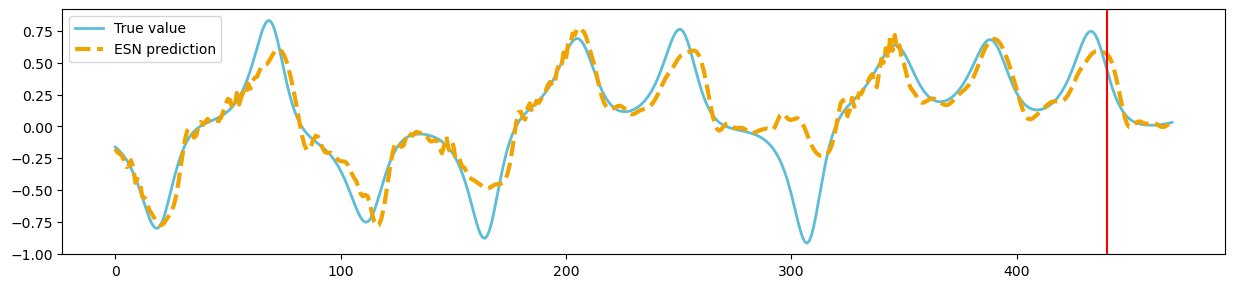

In [63]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import math
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4500
forecast = 30

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data

dt = 0.01
x0 = [-70.0, -28.0, 1000.0]

#000
x1 = data.lorenz(length=6500, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x1) 
X1 = time[:,0] 
X1 = X1.reshape(6500,1) 
X1 = 2 * (X1 - X1.min()) / (X1.max() - X1.min()) - 1 
#000
    
X = X1[:5000]


def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

units = 830
leak_rate = 0.55
spectral_radius = 0.6
input_scaling = 3.
connectivity = 0.51
input_connectivity = 0.51
regularization = 1.e-08
seed = 1934

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
###HERE1

In [64]:
def rmse(x_test, x_sim):
        res = 0
        for i in range(len(x_sim)):
            res = res + (x_sim[i] - x_test[i])**2
        res = math.sqrt(res/len(x_sim))
        return res

rmse(y_pred1[-100:], X[-100:])

C:\Users\nicks\AppData\Local\Temp\ipykernel_6188\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


0.08609235688141853

In [65]:
BestRmse = 0.24252096269990214
BestHyp = np.empty((8, 1))

BestHyp[0] = 830
BestHyp[1] = 0.55
BestHyp[2] = 0.6
BestHyp[3] = 3.
BestHyp[4] = 0.51
BestHyp[5] = 0.51
BestHyp[6] = 1.e-08
BestHyp[7] = 1934

units = 830
leak_rate = 0.55
spectral_radius = 0.6
input_scaling = 3.
connectivity = 0.51
input_connectivity = 0.51
regularization = 1.e-08
seed = 1934

In [66]:
Units = np.arange(700, 850, 50)
Leak_rate = np.arange(0.4, 0.6, 0.1)
Spectral_radius = np.arange(0.5, 0.7, 0.1)
Input_scaling = np.arange(2.5, 4.0, 1.0)
Connectivity = np.arange(0.51, 0.71, 0.1)
Input_connectivity = np.arange(0.51, 0.91, 0.1)
Regularization = np.arange((1.e-08)-1, (1.e-08)+1, 1.0)
Seed = np.arange(1734, 2434, 400)

In [67]:
print(Units.shape)
print(Leak_rate.shape)
print(Spectral_radius.shape) 
print(Input_scaling.shape) 
print(Connectivity.shape) 
print(Input_connectivity.shape) 
print(Regularization.shape) 
print(Seed.shape) 

(3,)
(2,)
(2,)
(2,)
(2,)
(4,)
(2,)
(2,)


In [68]:
for q in range(len(Units)):
    for w in range(len(Leak_rate)):
        
            for r in range(len(Input_scaling)):
                for t in range(len(Connectivity)):
                    for z in range(len(Input_connectivity)):
                        for u in range(len(Regularization)):
                            
                                #Первый тестовый набор параметров 
                                units = Units[q]
                                leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                
                                input_scaling = Input_scaling[r]
                                connectivity = Connectivity[t] #от 0 до 1
                                input_connectivity = Input_connectivity[z] #тоже %
                                regularization = Regularization[u]

                                #узел резервуара
                                reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                    lr=leak_rate, rc_connectivity=connectivity,
                                                    input_connectivity=input_connectivity, seed=seed)
                                #выходной слой(считывающее устройство)
                                readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                #соединяем узлы и таким образом получаем модель 
                                esn = reservoir >> readout

                                #обучение модели
                                esn = esn.fit(X_train1, y_train1)
                                #делаем предсказание
                                y_pred1 = esn.run(X_test1, reset=False)
                                #results(y_pred1, X[train+forecast:])
                                Rmse = rmse(y_pred1[-100:], X[-100:])
                                if (Rmse<BestRmse):
                                    BestRmse = Rmse
                                    BestHyp[0] = Units[q]
                                    BestHyp[1] = Leak_rate[w]
                                    
                                    BestHyp[3] = Input_scaling[r]
                                    BestHyp[4] = Connectivity[t]
                                    BestHyp[5] = Input_connectivity[z]
                                    BestHyp[6] = Regularization[u]
                            


Running Model-1166: 4500it [00:02, 1959.93it/s]<?, ?it/s]
Running Model-1166: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Fitting node Ridge-1166...


Running Model-1166: 470it [00:00, 2016.76it/s]           
C:\Users\nicks\AppData\Local\Temp\ipykernel_6188\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))
Running Model-1167: 4500it [00:02, 2091.79it/s]<?, ?it/s]
Running Model-1167: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Fitting node Ridge-1167...


Running Model-1167: 470it [00:00, 2206.29it/s]           
Running Model-1168: 4500it [00:02, 2133.71it/s]<?, ?it/s]
Running Model-1168: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Fitting node Ridge-1168...


Running Model-1168: 470it [00:00, 2397.89it/s]           
Running Model-1169:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
BestRmse, BestHyp

(0.03556220847892343,
 array([[8.00000000e+02],
        [5.00000000e-01],
        [6.00000000e-01],
        [2.50000000e+00],
        [5.10000000e-01],
        [7.10000000e-01],
        [1.00000001e-08],
        [1.93400000e+03]]))

In [ ]:
print(BestHyp[0])
print(BestHyp[1])
print(BestHyp[2])
print(BestHyp[3])
print(BestHyp[4])
print(BestHyp[5])
print(BestHyp[6])
print(BestHyp[7])

[800.]
[0.5]
[0.6]
[2.5]
[0.51]
[0.71]
[1.00000001e-08]
[1934.]


Running Model-1164: 4500it [00:02, 1588.12it/s]<?, ?it/s]
Running Model-1164: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Fitting node Ridge-1164...


Running Model-1164: 470it [00:00, 1779.46it/s]           


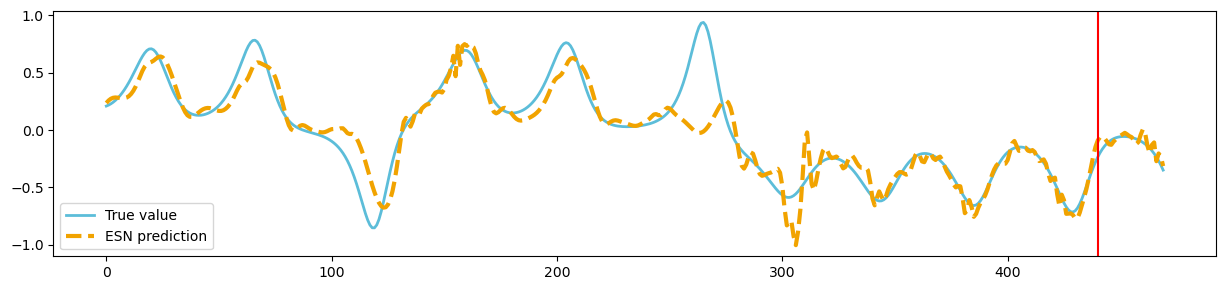

0.05355561059415119


C:\Users\nicks\AppData\Local\Temp\ipykernel_6188\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


In [ ]:
#Первый тестовый набор параметров 
units = 800
leak_rate = 0.5
spectral_radius = 0.6
input_scaling = 3.5
connectivity = 0.51
input_connectivity = 0.81
regularization = 1.00000001e-08
seed = 1734



#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
print(rmse(y_pred1[-100:], X[-100:]))
###HERE1

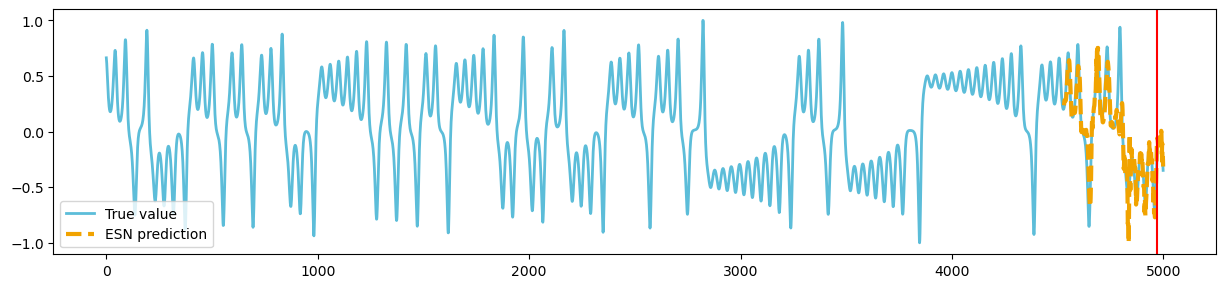

In [ ]:
tmp = np.full(5000-len(y_pred1), None)
y_pred1_extended = np.concatenate([tmp.reshape(len(tmp), 1), y_pred1])
results(y_pred1_extended, X)